In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from allennlp.modules.elmo import Elmo, batch_to_ids

import pickle



DS = pd.read_csv("ObjectSubset150SentenceLength.csv")
DS['tag'].fillna('text', inplace=True)
words = list(set(DS["word"].values))
n_words = len(words)
tags = list(set(DS["tag"].values))
n_tags = len(tags)

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(DS)
sentences = getter.sentences

max_len = 10
tags2 = ["PAD","object","text"]
tag2idx = {t: i  for i, t in enumerate(tags2)}

X = [[w[0] for w in s] for s in sentences]

new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    new_X.append(new_seq)
X = new_X

y = [[tag2idx[w[1]] for w in s] for s in sentences]

from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"], truncating='post')

idx2tag = {i: w for w, i in tag2idx.items()}

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2018)



batch_size = 32


# options_file = "options.json"
# weight_file = "swb_weights.hdf5"
# elmo_model  = Elmo(options_file, weight_file, 2, dropout=0)



# X_tr_character_ids = batch_to_ids(X_tr)
# X_tr_embeddings = elmo_model(X_tr_character_ids)
# pickle.dump(X_tr_embeddings, open('X_tr_embeddings.pickle', 'wb'))

# X_te_character_ids = batch_to_ids(X_te)
# X_te_embeddings = elmo_model(X_te_character_ids)
# pickle.dump(X_te_embeddings, open('X_te_embeddings.pickle', 'wb'))



# pickle.dump(y_tr, open('y_tr.pickle', 'wb'))
# pickle.dump(y_te, open('y_te.pickle', 'wb'))



Using TensorFlow backend.


In [2]:
max_len = 150
word2idx = {w: i + 2 for i, w in enumerate(words)}

word2idx["UNK"] = 1
word2idx["PAD"] = 0

In [3]:
from allennlp.modules.elmo import Elmo, batch_to_ids
options_file = "elmoembedings/options.json"
weight_file = "swb_weights.hdf5"
elmo_model  = Elmo(options_file, weight_file, 2, dropout=0)


In [4]:
# from keras.models import Model, Input
# from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


In [5]:
# X_tr_character_ids = batch_to_ids(X_tr)
# X_tr_embeddings = elmo_model(X_tr_character_ids)

# X_te_character_ids = batch_to_ids(X_te)
# X_te_embeddings = elmo_model(X_te_character_ids)

In [6]:
# Load pickle files that was prepared in UT server.
with open('elmoembedings\X_tr_embeddings.pickle', 'rb') as f:
    X_tr_embeddings = pickle.load(f)

with open('elmoembedings\X_te_embeddings.pickle', 'rb') as f:
    X_te_embeddings = pickle.load(f)

In [7]:
X_tr_embeddings['elmo_representations'][1].detach().numpy().shape

(10914, 35, 1024)

In [8]:
# sess.run(tf.compat.v1.global_variables_initializer())
# sess.run(tf.compat.v1.tables_initializer())
# def ElmoEmbedding(x):
#     return elmo_model(inputs={
#                             "tokens": tf.squeeze(tf.cast(x, tf.string)),
#                             "sequence_len": tf.constant(batch_size*[max_len])
#                       },
# #                       signature="tokens",
#                       as_dict=True)["elmo"]

# from keras.models import Model, Input
# from keras.layers.merge import add
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# input_text = Input(shape=(max_len,), dtype=tf.string)
# embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
# x = Bidirectional(LSTM(units=512, return_sequences=True,
#                        recurrent_dropout=0.2, dropout=0.2))(embedding)
# x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(x)
# x = add([x, x_rnn])  # residual connection to the first biLSTM
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)


In [9]:
X_tr_embeddings["elmo_representations"][1].shape

torch.Size([10914, 35, 1024])

In [10]:
# Load pickle files that was prepared in UT server.
with open('elmoembedings/y_tr.pickle', 'rb') as f:
    y_tr = pickle.load(f)

with open('elmoembedings/y_te.pickle', 'rb') as f:
    y_te = pickle.load(f)

In [11]:
y_tr.shape

(10914, 35)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, core, Activation, Dense
import numpy as np
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


model = Sequential()
# model.add(TimeDistributed(LSTM(units=20,input_shape=(10, 1024), return_sequences=False,
#                                 recurrent_dropout=0.5)))

# # main LSTM
# model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(20, input_shape=(10, 1024), return_sequences=True,recurrent_dropout=0.5)))

model.add(TimeDistributed(Dense(3, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [13]:
history = model.fit(X_tr_embeddings['elmo_representations'][1].detach().numpy(), y_tr.reshape(y_tr.shape[0],35,1),validation_split=0.1 ,verbose=1,epochs=10,batch_size=32)

Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 14s 1ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0065 - val_accuracy: 0.9986
Epoch 2/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 3/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 4/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 5/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 6/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 7/10
9822/9822 [==============================] - 13s 1ms/step - loss: 0.001

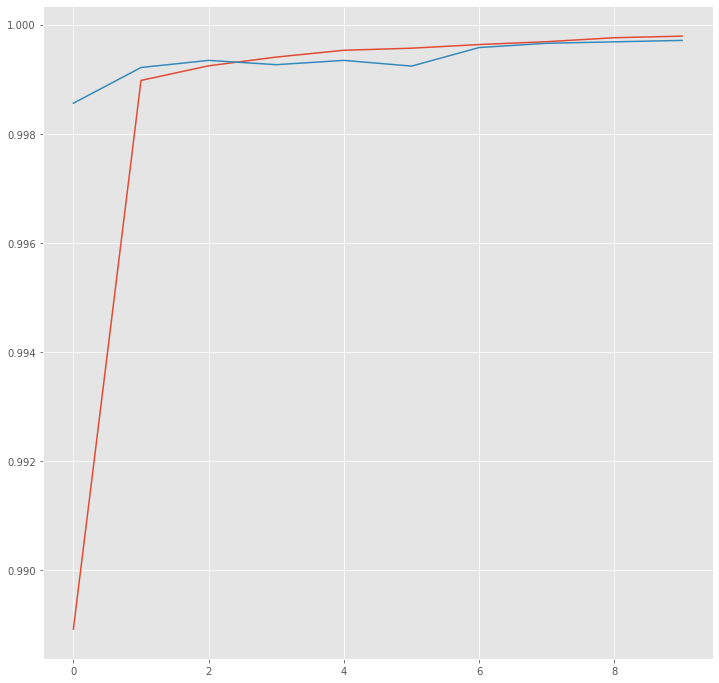

In [14]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [15]:
y_pred = model.predict(X_te_embeddings['elmo_representations'][1].detach().numpy(),verbose=1)

2729/2729 [==============================] - 1s 442us/step


In [16]:
y_pred[1]

array([[1.00827765e-05, 3.60560916e-05, 9.99953866e-01],
       [5.35005893e-06, 1.57046743e-05, 9.99978900e-01],
       [3.97064832e-06, 3.07798728e-05, 9.99965191e-01],
       [5.12398128e-06, 6.85779887e-05, 9.99926329e-01],
       [2.79996166e-05, 1.69808525e-04, 9.99802172e-01],
       [1.06894462e-04, 9.92597103e-01, 7.29608303e-03],
       [1.01237143e-04, 9.82100427e-01, 1.77982841e-02],
       [5.99759442e-05, 5.55738399e-04, 9.99384284e-01],
       [1.64341018e-05, 6.80143858e-05, 9.99915600e-01],
       [5.23938024e-06, 6.10688403e-06, 9.99988675e-01],
       [9.07158847e-06, 5.37968708e-06, 9.99985576e-01],
       [9.99949455e-01, 4.39571704e-06, 4.61376148e-05],
       [9.99974251e-01, 1.46868399e-06, 2.42922342e-05],
       [9.99983549e-01, 1.03436457e-06, 1.53696637e-05],
       [9.99985933e-01, 8.72866281e-07, 1.32077266e-05],
       [9.99986529e-01, 8.16391605e-07, 1.26719051e-05],
       [9.99986649e-01, 7.86850705e-07, 1.25212300e-05],
       [9.99987006e-01, 7.68453

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 35, 40)            167200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 35, 3)             123       
Total params: 167,323
Trainable params: 167,323
Non-trainable params: 0
_________________________________________________________________


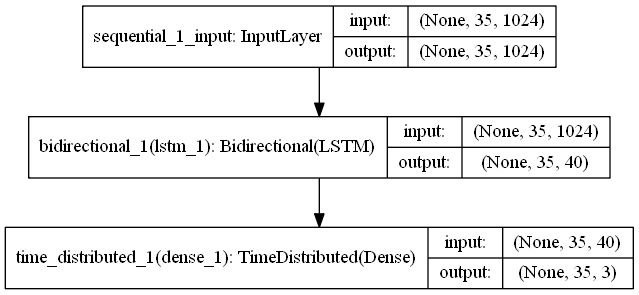

In [18]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Elmo_Model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
y_te[1]

array([2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
            out_i.append(idx2tag[p_i].replace("PAD","text"))
        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD","text"))
        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [21]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 98.1%


In [22]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

     text       0.98      0.98      0.98      4419
   object       0.99      0.97      0.98      2068

micro avg       0.99      0.98      0.98      6487
macro avg       0.99      0.98      0.98      6487



In [23]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

      object       1.00      0.98      0.99      3588
        text       1.00      1.00      1.00     91927

    accuracy                           1.00     95515
   macro avg       1.00      0.99      0.99     95515
weighted avg       1.00      1.00      1.00     95515



In [24]:
j = 0
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))

for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print(30 * "=")
    for w, t, pred in zip(X_te[i], y_te[i], p):
        if w != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(w, idx2tag[t], idx2tag[pred]))
                j = j+1


Word           ||True ||Pred
KORRAS.        : object text
KOORMUSTEST-KORRAS: object text
24-tunni       : object text
130/82         : object text
130/95         : object text
min.Pikkus     : object text
170            : object text
rr125/80       : text  object
RR-monitooringul: object text
114/73         : object text
145/80mmHg     : text  object
52Pikkus       : object text
166            : object text
rR             : text  object
136/84         : text  object
140            : object text
157/94         : object text
regRR140-90mmhg: object text
170/100        : object text
140/94--&gt;   : object text
140/90         : object text
142/78         : text  object
160/100mmHg    : text  object
170cm          : object text
13-101035-1    : object text
RR-le          : object text
156/86         : object text
id="0"         : object text
RRmonitooringul: object text
110            : object text
03.06.2010     : object text
120x1          : object text
120x1          : object text
AVR 

In [25]:
j

47

In [26]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler
# https://eli5.readthedocs.io/en/latest/autodocs/lime.html

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, tag2idx, max_len):
        self.model = model
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        self.max_len = max_len
        
    def _preprocess(self, texts):

        X = [[w[0] for w in s] for s in sentences]
        new_X = []
        for seq in X:
            new_seq = []
            for i in range(max_len):
                try:
                    new_seq.append(seq[i])
                except:
                    new_seq.append("PAD")
            new_X.append(new_seq)
        X = new_X
        X = batch_to_ids(X)
        X = elmo_model(X)


        return X['elmo_representations'][1].detach().numpy()
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func


In [28]:
labels = [[s[1] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'26.05.09 patsient hospitaliseeritud erütrotsüütide ülekandeks, 2 doosi RR 120/85 temperatuur 37.7. Võetud vereanalüüsid. Enesetunne rahuldav.'

In [29]:
Sentneceindex = 21
label = labels[20:22]
text = sentences[20:22]
# print(label)
# print(text)

text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Põhjendus: (text) 6A (text) dünaamikas (text) Kirjeldus: (text) Võrreldes (text) 23.10 (text) tehtud (text) ü/v-ga (text) dünaamika (text) puudub. (text) Pikkus-165, (object) kaal-107,6. (text) v/s-10,5 (text) tühjalt. (text)


In [30]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")


0: Põhjendus:
1: 6A
2: dünaamikas
3: Kirjeldus:
4: Võrreldes
5: 23.10
6: tehtud
7: ü/v-ga
8: dünaamika
9: puudub.
10: Pikkus-165,
11: kaal-107,6.
12: v/s-10,5
13: tühjalt.


In [31]:
explainer_generator = NERExplainerGenerator(model, tag2idx, max_len)


In [32]:
word_index = 10
predict_func = explainer_generator.get_predict_function(word_index=word_index)


In [33]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=10))


(('Põhjendus: 6A UNK Kirjeldus: Võrreldes UNK.10 UNK ü/v-ga dünaamika puudub. Pikkus-UNK, kaal-107,UNK. v/s-10,5 tühjalt.', 'Põhjendus: UNK dünaamikas Kirjeldus: UNK UNK.10 UNK ü/UNK-ga UNK puudub. Pikkus-165, kaal-UNK,UNK. UNK/s-UNK,5 tühjalt.', 'Põhjendus: UNK dünaamikas Kirjeldus: UNK 23.10 UNK UNK/UNK-ga dünaamika puudub. Pikkus-UNK, UNK-107,UNK. v/s-UNK,UNK tühjalt.', 'Põhjendus: 6A dünaamikas Kirjeldus: Võrreldes 23.10 tehtud ü/v-UNK dünaamika puudub. Pikkus-165, kaal-107,6. v/s-10,5 tühjalt.', 'UNK: UNK dünaamikas Kirjeldus: Võrreldes UNK.10 UNK ü/v-ga dünaamika UNK. UNK-UNK, UNK-107,6. v/s-10,5 tühjalt.', 'Põhjendus: UNK dünaamikas Kirjeldus: Võrreldes UNK.10 tehtud UNK/v-UNK dünaamika UNK. UNK-165, UNK-107,UNK. UNK/UNK-UNK,5 UNK.', 'UNK: UNK dünaamikas UNK: Võrreldes 23.UNK UNK UNK/UNK-UNK UNK UNK. UNK-165, UNK-107,UNK. UNK/s-10,UNK UNK.', 'Põhjendus: 6A dünaamikas Kirjeldus: Võrreldes UNK.10 tehtud ü/v-ga dünaamika puudub. Pikkus-UNK, kaal-107,6. v/s-10,UNK tühjalt.', 'Põhjen

In [34]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)
# https://github.com/TeamHG-Memex/eli5/blob/017c738f8dcf3e31346de49a390835ffafad3f1b/eli5/explain.py#L83


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 25482067968 bytes. Buy new RAM!


In [ ]:
# sentences = [['minu', 'nimi' ,'on', 'nesma', 'hästi', 'Eemaldatud', '700', 'ml', 'plasmat','RR',' 112/60',' mmHg'], ['Pt.', 'tehtud' ,'plasmaferees', 'talus', 'hästi']]
# character_ids = batch_to_ids(sentences)
# embeddings = elmo(character_ids)
# scipy.spatial.distance.cosine(embeddings['elmo_representations'][1][1][4].detach().numpy(),embeddings['elmo_representations'][1][1][1].detach().numpy())